# First-time Home Buyers Dataset Analysis

### Import packages and <a href="https://drive.google.com/file/d/1sCY9CA7IO7rSXrp9OYW2AKHJxusD68jD/view?usp=sharing">original dataset</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
df=pd.read_csv('mortgages.csv', low_memory=False)

print(df.shape)

(1063316, 101)


### 1 - Estimate which subset of the dataset is first-time home buyers in New York and New England, and whether that subset is large enough for analysis

In order to determine the subset of first-time home buyers, the dataset is filtered based on the following criteria:
* **Loan Purpose**: Because first-time home buyers have not owned a property before, it is reasonable to conclude that their purpose for getting a loan mortgage is to purchase a new home, not to refinance. Thus, I filter the dataset to keep only value ‘1’, which is Home purchase, in *loan_purpose* column.
* **Business or Commercial Purpose**: The main purpose of this report is to focus on first-time home buyers, so I exclude the mortgage applications for business or commercial purpose. Specifically, I remove all entries that have value ‘1’ in *business_or_commercial_purpose* column.
* **Occupancy Type**: Only home buyers looking to purchase a primary residence are included because second residence and investment property purchase tend to have stricter and more complicated requirements which first-time home buyers typically can’t qualify. Therefore, only entries with value ‘1’ in *occupancy_type* column remain in our subset.
* **Applicant and Co-applicant Age**: First-time home buyers’ median age has been in the 31 to 34 range in the past years, which gives me a motive to exclude applicants and co-applicants whose age is above 62. In other words, entries with value ‘Yes’ in *applicant_age_above_62* and *co_applicant_age_above_62* columns are eliminated.
* **Reverse Mortgage**: As explained above, applicants who are above 62 years old are unlikely to purchase a home for the first time. Reverse mortgage is designed solely for seniors who are 62 years old or older, in which lenders pay the homeowners. Consequently, applications that are reported as reverse mortgage are excluded and entries with value ‘1’ in *reverse_mortgage* column are removed.

Additionally, while examining the summary statistics of *income* and *loan_amount* columns, there are multiple negative values in *income* column and a few extremely high outliers in both columns, which could be due to data errors. Therefore, I only keep entries that have income and loan amount between 0 and 15 million dollars. I also divided *loan_amount* and *property_value* columns by 1,000 so that the values will be in thousands of dollars to make it consistent with income column values for more accurate comparisons.

After applying the above filters and removing 3 redundant columns, the final data subset contains 349,093 rows and 99 columns, which is approximately 33% of the original data. This filtered portion reasonably represents the first-time home buyers segment and is large enough to proceed with more detailed analyses.



In [3]:
# CLEAN ORIGINAL DATA

# drop redundant columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'activity_year'], inplace=True, axis=1)

# add column for 'approved' or 'denied' status
def loan_status (row):
    if (row.action_taken == 1) | (row.action_taken == 6) | (row.action_taken == 2) | (row.action_taken == 8):
        return 'Approved'
    if (row.action_taken == 3) | (row.action_taken == 7):
        return 'Denied'
df['loan_status']=df.apply(loan_status,axis=1) 

# make loan_amount in thousands of dollars unit to be consistent with income unit
df['loan_amount'] = df['loan_amount']/1000

# df.info()

In [4]:
# EXTRACT DATA SUBSET

subset = df[(df.loan_purpose == 1) #keep "Home Purchase" for loan purpose
        & (df.business_or_commercial_purpose != 1) #remove business/commercial purpose
        & (df.occupancy_type == 1) #keep only "principal residence" 
        & (df.applicant_age_above_62 != 'Yes') 
        & (df.co_applicant_age_above_62 != 'Yes')
        & (df.reverse_mortgage != 1) #remove those qualifies for reverse mortgage
        ]

# exclude outliers in income and loan_amount columns
subset=subset[(subset.income.between(0, 15000)) & (subset.loan_amount <= 15000)]

print(subset.shape)
# print(subset.info())

(349093, 99)


### 2 - Exploratory Data Analysis

#### Demographics of first-time home buyers

First of all, I analyze the demographics of first-time home buyers in order to provide a general idea of who these buyers are. 

* There are approximately 230,000 mortgage applications from buyers in 25-34 and 35-44 age groups in 2018, which account for two-third of the first-time buyers subset. 
* There are more male applicants than female applicants; however, joint applicants actually make up for the biggest fraction as couples are more likely to buy a home for their new families. 
* Nearly 70% of the first-time home buyers subset is White, followed by only 8% of Asian and 5% of Black or African American. 

In [5]:
# age
age=pd.DataFrame(subset.applicant_age.value_counts())
age=age.reindex(['<25','25-34','35-44','45-54','55-64','8888'])
age.columns=['Applications']
age['Median income']=subset.groupby('applicant_age')['income'].median()
age['Median loan_amount']=subset.groupby('applicant_age')['loan_amount'].median()
age['Median interest rate']=subset.groupby('applicant_age')['interest_rate'].median()
age=age.rename(index={'8888': 'No info'})

# gender
gender=pd.DataFrame(subset.derived_sex.value_counts())
gender.columns=['Applications']
gender['Median income']=subset.groupby('derived_sex')['income'].median()
gender['Median loan_amount']=subset.groupby('derived_sex')['loan_amount'].median()
gender['Median interest rate']=subset.groupby('derived_sex')['interest_rate'].median()

# race
race=pd.DataFrame(subset.derived_race.value_counts())
race.columns=['Applications']
race['Median income']=subset.groupby('derived_race')['income'].median()
race['Median loan_amount']=subset.groupby('derived_race')['loan_amount'].median()
race['Median interest rate']=subset.groupby('derived_race')['interest_rate'].median()
race=race.reindex(['American Indian or Alaska Native','Asian','Black or African American',
                 'Native Hawaiian or Other Pacific Islander','White','2 or more minority races',
                 'Joint','Free Form Text Only','Race Not Available'])

In [6]:
sns.set(style='darkgrid', font_scale=1) #set overall graph style

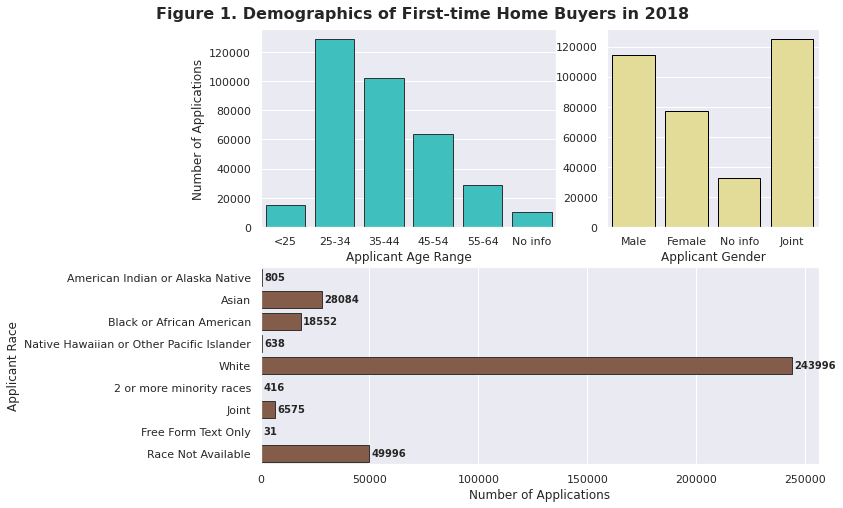

In [7]:
# subplots for demographics graphs
gs=gridspec.GridSpec(2,2,width_ratios=[1.4,1])
fig= plt.figure(figsize=(10,8))

# age bar chart
ax=plt.subplot(gs[0,0])
age_fig=sns.barplot(x=age.index, y='Applications', data=age, color='cyan',
                      saturation=.5, edgecolor='.2')
age_fig.set(ylabel='Number of Applications', xlabel='Applicant Age Range')

fig.suptitle('Figure 1. Demographics of First-time Home Buyers in 2018',
          ha='center', weight='bold', fontsize=16, x=.35, y=.92)

# gender bar chart
ax=plt.subplot(gs[0,1])
gender_fig=sns.countplot(x='derived_sex', data=subset, color='khaki', 
                      edgecolor='black')
gender_fig.set_xticklabels(['Male','Female','No info','Joint'])
gender_fig.set(xlabel='Applicant Gender', ylabel='')

# race bar chart
ax=plt.subplot(gs[1,:])
race_fig=sns.barplot(y=race.index, x='Applications', data=race, color='sienna',
                      saturation=.5, edgecolor='.2')
race_fig.set(xlabel='Number of Applications', ylabel='Applicant Race')
for i in race_fig.patches:
    race_fig.text(i.get_width()+1000, i.get_y()+0.52, str(int(i.get_width())),
                  fontweight='bold', fontsize=10)                 
plt.show()

* Even though age group 35-44 has the highest median income and loan amount in the first-time buyers subset, the median interest rates are almost the same for all age groups.

* Similarly, in all gender groups, “joint” gender, assuming to be couples, has the highest median income and median loan amount but median interest rate also remains constant across all groups.

* On the other hand, American Indian or Alaska Native group has the lowest median income and median loan amount but has the highest median interest rate along with Black or African American. Asian group has the highest median income and median loan amount out of the reported race groups but has the lowest median interest rate.

* There is a positive correlation between median loan amount and median income regardless of demographic attributes. 
* While median income and median loan amount do not seem to affect median interest rate when classify the data by age and sex, there are negative correlations between median interest rate and median income as well as between median interest rate and median loan amount when the dataset is broken down by races. Particularly, higher income and higher loan amount as individual variables result in lower interest rate.  


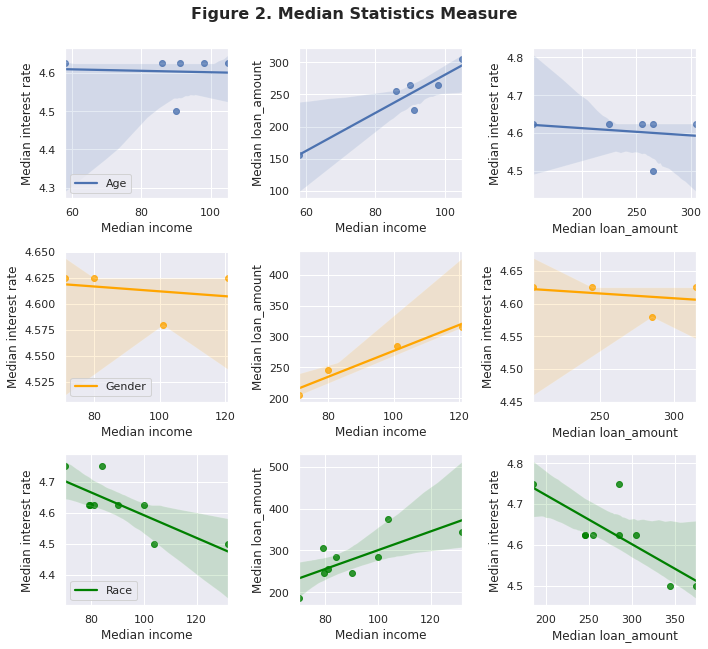

In [8]:
# regression plots for relationships among income, loan amount, interest rate

fig, ax = plt.subplots(3,3,figsize=(10,9))
fig.suptitle('Figure 2. Median Statistics Measure', x=.5, y=1,fontsize=16, fontweight='bold')
age_income_interest = sns.regplot(data=age, x='Median income',y='Median interest rate', ax=ax[0,0])
age_income_loan = sns.regplot(data=age, x='Median income',y='Median loan_amount', ax=ax[0,1])
age_loan_interest = sns.regplot(data=age, x='Median loan_amount',y='Median interest rate', ax=ax[0,2])

gender_income_interest = sns.regplot(data=gender, x='Median income',y='Median interest rate', ax=ax[1,0], color='orange')
gender_income_loan = sns.regplot(data=gender, x='Median income',y='Median loan_amount', ax=ax[1,1], color='orange')
gender_loan_interest = sns.regplot(data=gender, x='Median loan_amount',y='Median interest rate', ax=ax[1,2], color='orange')

race_income_interest = sns.regplot(data=race, x='Median income',y='Median interest rate', ax=ax[2,0], color='green')
race_income_loan = sns.regplot(data=race, x='Median income',y='Median loan_amount', ax=ax[2,1], color='green')
race_loan_interest = sns.regplot(data=race, x='Median loan_amount',y='Median interest rate', ax=ax[2,2], color='green')

age_income_interest.legend(labels=['Age'])
gender_income_interest.legend(labels=['Gender'], loc='lower left')
race_income_interest.legend(labels=['Race'], loc='lower left')

plt.tight_layout()
plt.show()

#### Denial Rate by Races

* From column *action_taken* in the dataset, I added a new column called loan_status to categorize “Accepted” and “Denied” applications.
    * Accepted applications include value ‘1’- Loan originated, ‘2’- Application approved but not accepted, ‘6’- Purchased loan, and ‘8’- Preapproval request approved but not accepted.
    * Denied applications include value ‘3’- Application denied, and ‘7’- Preapproval request denied.
    
* The denial rate is calculated by dividing the number of denied applications by the total number of applications in the subset. 

* Denial rate for American Indian or Alaska Native is the highest with over 23%. The denial rates for Native Hawaiian or Other Pacific Islander and 2 or more minority races are also over 20%. Even though there are only under 1,000 mortgage applications for each of these races, which is a very small portion of the subset, these groups have the highest denial rates. In other words, only a small number of applicants who are in minority races qualify for mortgage loans to finance for their new homes.

* There are about 50,000 applications that do not report applicants’ race and 6,500 applications with “Joint” race, which could affect the analysis to some extend but it is undeniable that the denial rates of minority races almost double those of others.

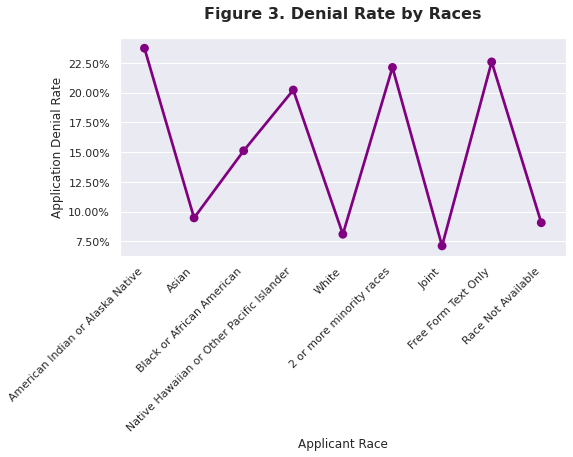

In [9]:
# Number of applicants classified by race and state
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
all_by_race_table=pd.crosstab(subset.derived_race,df.state_code,margins=True)
# print(table1)

# Number of denied applicants classified by race and state
Denied_data=subset[subset.loan_status == 'Denied']
denied_table=pd.crosstab(Denied_data.derived_race,Denied_data.state_code,margins=True)
# print(table2)

# Percentage of denied applicants classified by race and state
denied_by_race_table=denied_table/all_by_race_table
denied_by_race_table.fillna(0, inplace=True)
denied_by_race_table=denied_by_race_table[['MA','ME','NH','NY','RI','VT','All']]
denied_by_race_table=denied_by_race_table.reindex(['American Indian or Alaska Native','Asian','Black or African American',
                 'Native Hawaiian or Other Pacific Islander','White','2 or more minority races',
                 'Joint','Free Form Text Only','Race Not Available'])
# print(table3)

# line plot 
fig, ax = plt.subplots(figsize=(8,4))
race_rate=sns.pointplot(x=denied_by_race_table.index, y='All', data=denied_by_race_table, color='purple')
race_rate.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.2f%%" %(x * 100)))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Applicant Race')
plt.ylabel('Application Denial Rate')
plt.title('Figure 3. Denial Rate by Races', weight='bold', fontsize=16, pad=20)

plt.show()

#### Denial Reasons For Rejected Applications

HMDA requires financial institutions to report reasons for denied applications or denied preapproval requests. In this dataset, there are 8 specific denial reasons recorded. For a total of 30,000 denied applications, the most reported denial reason is Debt-to-Income Ratio, followed by Credit History and Collateral.

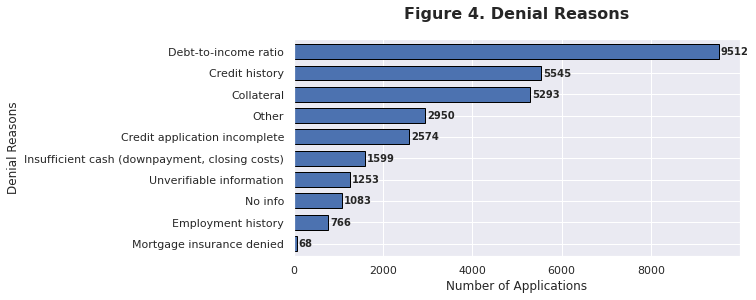

In [10]:
denial_reason_df=pd.DataFrame(subset[subset['loan_status'] == 'Denied'].denial_reason_1.value_counts())
denial_reason_df=denial_reason_df.rename(index={1: 'Debt-to-income ratio', 
                                                2: 'Employment history',
                                                3: 'Credit history',
                                                4: 'Collateral',
                                                5: 'Insufficient cash (downpayment, closing costs)',
                                                6: 'Unverifiable information',
                                                7: 'Credit application incomplete',
                                                8: 'Mortgage insurance denied',
                                                9: 'Other',
                                                1111: 'No info'})

# bar plot
denial_reason_graph=denial_reason_df.plot(kind='barh', figsize=(8,4), edgecolor='black', width=.7)
denial_reason_graph.get_legend().remove()
denial_reason_graph.invert_yaxis() #sort bars in descending order
denial_reason_graph.set(xlabel='Number of Applications', ylabel='Denial Reasons')
# add numbers of applications for each bar
for i in denial_reason_graph.patches:
    denial_reason_graph.text(i.get_width()+50, i.get_y()+0.5, str(round((i.get_width()), 2)), 
                             fontweight='bold', fontsize=10)
plt.title('Figure 4. Denial Reasons', weight='bold', fontsize=16, pad=20)

plt.show()

#### Debt-to-Income Ratio

* Debt-to-income ratio measures the amount of debt the applicants have to their gross income, which helps lenders determine whether the applicants have the ability to afford monthly mortgage payments. 

* Low debt-to-income ratio is preferable while high ratio indicates that the applicant might have too much liability and is riskier to lenders. However, there is no established “passing” debt-to-income ratio target, so I analyze the denial rate by debt-to-income ratios.

* The denial rate remains under 10% for debt-to-income ratio from 20% to 45%.

* Starting with ratio of 46% onwards, the denial rates seem to increase closer to 10% and jumps to 23% with 50%-60% ratio mark. 

* Over 80% of the applications with more than 60% debt-to-income ratio are rejected. 

* Surprisingly, even with a debt-to-income ratio of under 20%, the denial rate is about 11% which is noticeably higher than other ratio levels. A potential explanation is that these applicants have not had established credit history due to the lack of frequent liability payments; therefore, they might be rejected because of credit history reason rather than debt-to-income ratio. 

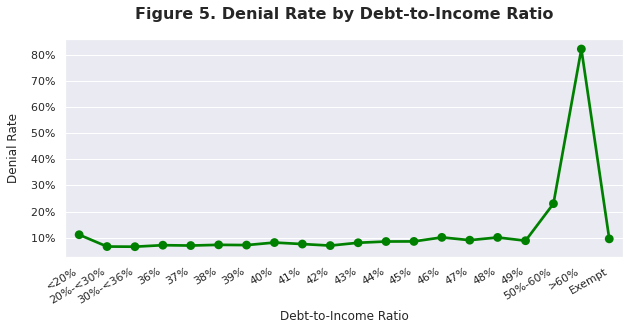

In [11]:
# Number of applicants classified by debt/income and state
all_by_debt_ratio_table=pd.crosstab(subset.state_code,subset.debt_to_income_ratio,margins=True)

# Number of denied applicants classified by debt/income and state
denied_by_debt_ratio_table=pd.crosstab(Denied_data.state_code,Denied_data.debt_to_income_ratio,margins=True)

# Percentage of denied applicants classified by debt/income and state
denied_pct_table=denied_by_debt_ratio_table/all_by_debt_ratio_table

# selecting only 'All' row
denied_pct_table_sub=pd.DataFrame(denied_pct_table.loc['All'])
denied_pct_table_sub.drop('All')
denied_pct_table_sub=denied_pct_table_sub.reindex(['<20%','20%-<30%','30%-<36%','36','37','38','39','40',
                 '41','42','43','44','45','46','47','48','49','50%-60%',
                 '>60%','Exempt'])
denied_pct_table_sub=denied_pct_table_sub.rename(index={'36':'36%','37':'37%','38':'38%','39':'39%','40':'40%',
                 '41':'41%','42':'42%','43':'43%','44':'44%','45':'45%','46':'46%','47':'47%',
                 '48':'48%','49':'49%'})

# line plot
fig, ax = plt.subplots(figsize=(10,4))
ratio_rate=sns.pointplot(x=denied_pct_table_sub.index, y='All', data=denied_pct_table_sub, color='green')
ratio_rate.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%4d%%'%(x * 100)))
plt.xticks(rotation=30, ha='right')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Denial Rate')
plt.title('Figure 5. Denial Rate by Debt-to-Income Ratio', weight='bold', fontsize=16, pad=20)

plt.show()

#### Loan Types

* Approximately 83% the total mortgage loan applications are for Conventional loan while only 12% of applications are for FHA loan. Conventional loans are believed to provide more flexibility to borrowers in term of down payment options, loan term lengths, etc. Thus, conventional loans are more common to home buyers. 

* Only about one-third of the Conventional loan applications are from first-time home buyers. It is possible that first-time home buyers are less likely to qualify for Conventional loan. Because Conventional loan is not guaranteed by the government, the lender is at risk if the borrower cannot make mortgage payments so Conventional loan typically has higher requirements.

* Nearly 50% of the FHA loan applications are from first-time buyers. FHA loan is one of the government-backed loans, which requires lower income and lower credit score, making it easier for first-time home buyers to be qualified. 

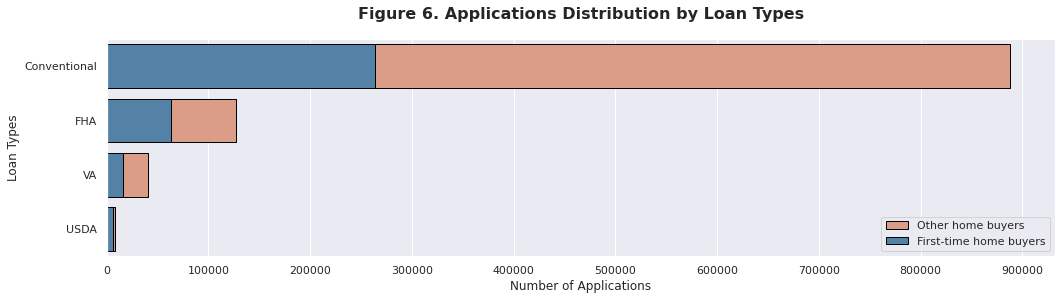

In [12]:
# Number of applications by loan types for both first-time buyers subset and all buyers

all_loan = df.loan_type.value_counts()/len(df.loan_type)
first_time_loan = subset.loan_type.value_counts()/df.loan_type.value_counts()

# bar chart
fig, ax = plt.subplots(figsize=(17,4)) #change graph size

all_buyers=sns.countplot(y='loan_type', data=df, color='darksalmon', edgecolor='black')
ft_buyers=sns.countplot(y='loan_type', data=subset, color='steelblue', edgecolor='black')

plt.legend(labels=['Other home buyers', 'First-time home buyers'], loc='lower right')
all_buyers.set_xticks([0,100000,200000,300000,400000,500000,600000,700000,800000,900000])
all_buyers.set_yticklabels(['Conventional', 'FHA','VA','USDA'])
plt.xlabel('Number of Applications')
plt.ylabel('Loan Types')
plt.title('Figure 6. Applications Distribution by Loan Types', weight='bold', fontsize=16, pad=20)
plt.show()

### 3 - Statistical Analysis

#### Bootstrap confidence intervals

I want to obtain more insights on *income*, *loan_amount*, and *property_value* columns but because the subset of first-time home buyers is only an estimation, I'm not confident that the data accurately represents the actual population of first-time home buyers. There are many outliers that could drastically affect the analysis. However, there is not enough evidence to surely determine whether these outliers are rare exceptions, or that they actually don’t belong in this subset. Therefore, I consider this current data subset as a sample of first-time buyers’ population. I compute bootstrap confidence intervals of *income*, *loan_amount*, and *property_value* columns to get a more assured results.

* Generate bootstrap replicates and calculate the 90% confidence intervals for *income*, *loan_amount*, and *property_value* columns. 

* A size of 10,000 is used for the bootstrap replicates because this is a large dataset and it would take a long time to complete the analysis with larger size.

* Confidence intervals give us the estimation of discrepancy from the sample mean to population mean. With a 90% confidence interval, we can be 90% confident that the interval will contain the actual population mean.

    * __Income:__ The 90% confidence interval for income is between 125.91545 and 126.82015, meaning the average income of the first-time home buyers segment is around $125,915 to $126,820.
    * __Loan Amount:__ The 90% confidence interval for loan amount is between 323.98419 and 325.48487. This range indicates that first-time home buyers apply for mortgage loan of $324,984 to $325,485 on average.
    * __Property Value:__ The 90% confidence interval for property value is between 423.34171 and 426.3167, indicating that first-time home buyers apply for mortgage loan to finance a home with an average price of $423,342 to $426,317.



In [13]:
# make values in property_value column in thousands of dollars
# to be consistent with income and loan amount
subset['property_value']= subset.property_value/1000

# Draw bootstrap replicates
def draw_bs_reps(data, func,size=1):
    n = len(data)
    reps = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, n)
        reps[i] = func(bs_sample)     
    return reps

# bootstrap confidence interval of income
print('income')
bs_reps_income =draw_bs_reps(subset['income'], np.mean, size=10000)
sem = np.std(subset.income) / np.sqrt(len(subset.income))
print(sem)

conf_int = np.percentile(bs_reps_income,[5,90])
print('90% confidence interval =', conf_int)
print()

# bootstrap confidence interval of loan amount
print('loan_amount')
bs_reps_loan_amount =draw_bs_reps(subset['loan_amount'], np.mean, size=10000)
sem = np.std(subset.loan_amount) / np.sqrt(len(subset.loan_amount))
print(sem)

conf_int = np.percentile(bs_reps_loan_amount,[5,90])
print('90% confidence interval =', conf_int)
print()

# exclude nan values for the confidence interval test
subset1=subset[(subset.property_value>0)]

# bootstrap confidence interval of property_value 
print('property_value')
bs_reps_property_value =draw_bs_reps(subset1['property_value'], np.mean, size=10000)
sem = np.std(subset1.property_value) / np.sqrt(len(subset1.property_value))
print(sem)

conf_int = np.percentile(bs_reps_property_value,[5,90])
print('90% confidence interval =', conf_int)


income
0.30595489405646603
90% confidence interval = [125.91480637 126.80750774]

loan_amount
0.5151992716787293
90% confidence interval = [323.97028299 325.49389991]

property_value
1.0060019567439649
90% confidence interval = [423.39323004 426.33247792]


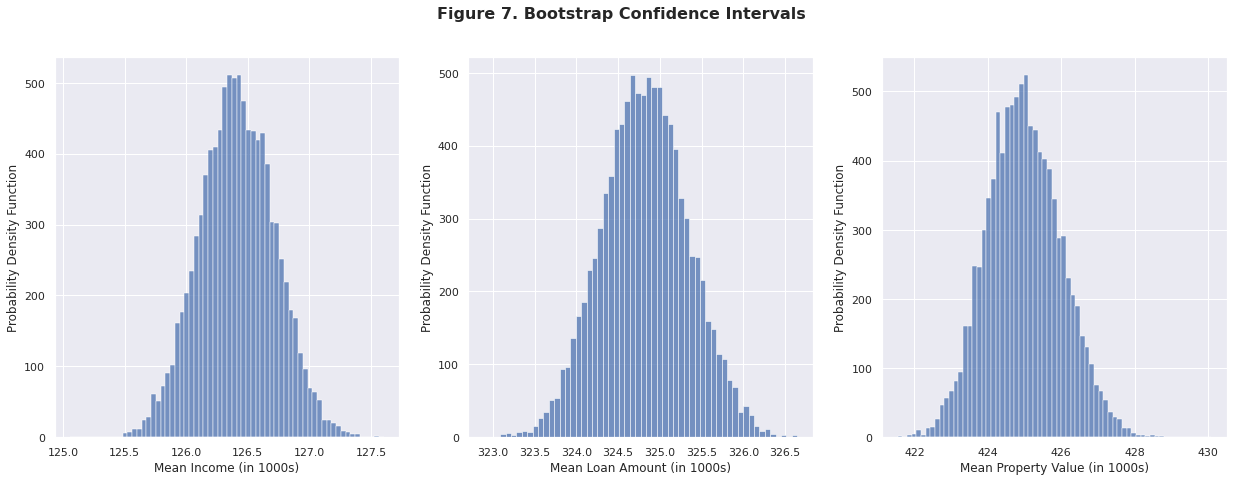

In [14]:
# histogram plots
fig=plt.figure(figsize=(21,7))

plt.subplot(1,3,1)
inc_ci= sns.histplot(bs_reps_income)
inc_ci.set(xlabel='Mean Income (in 1000s)', ylabel='Probability Density Function')

plt.subplot(1,3,2)
loan_ci= sns.histplot(bs_reps_loan_amount)
loan_ci.set(xlabel='Mean Loan Amount (in 1000s)', ylabel='Probability Density Function')

plt.subplot(1,3,3)
value_ci= sns.histplot(bs_reps_property_value)
value_ci.set(xlabel='Mean Property Value (in 1000s)', ylabel='Probability Density Function')

fig.suptitle('Figure 7. Bootstrap Confidence Intervals', fontweight='bold', fontsize=16)
plt.show()

### 4 - Machine Learning Technique

#### Logistic Regresion Model

Since I could not identify clear direct relationships due to data variation in this dataset, logistics regression model is a good method to quantify the correlations of different components. Based on the exploratory data analysis and statistical summary, I select 7 candidate variables including *applicant_age*, *debt_to_income_ratio*, *income*, *loan_amount*, *derived_sex*, *loan_type*, and *derived_race* to build the logistic regression model.The response of this model is the odds of application approved/ odds of application denied.
* The ‘Approved’ value in loan_status column is replaced with number 1 and ‘Denied’ value with number 0.
* In order to reduce the number of dummy variables, I convert string values of *applicant_age* and *debt_to_income_ratio* columns into numeric value.
* Rows with *derived_race* = ‘race not available’, *derived_sex* = ‘sex not available’, and *applicant_age* = ‘Exempt’ are removed.
* The data subset used for the regression model contains 263,043 observations, around one-third of the original data.

In [15]:
# Change age to numeric data
subset['applicant_age'] = subset['applicant_age'].replace(['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74'], [22,30,40,50,60,70,79])

# Change string of debt_to_income_ratio to numeric data
subset['debt_to_income_ratio'] = subset['debt_to_income_ratio'].replace(['<20%', '20%-<30%', '30%-<36%', '50%-60%', '>60%'], [10,25,33,55,70])

In [16]:
# Create new dataframe that include only variables for regression model
regressiondata = subset[['loan_status','income', 'loan_amount','applicant_age','debt_to_income_ratio']]

# Remove not avaible values and nan values
regressiondata = regressiondata.replace('Exempt',None)
regressiondata = regressiondata.drop(regressiondata[regressiondata['applicant_age'] == '8888'].index)
subset = subset.replace(['Race Not Available', 'Sex Not Available'],None)
regressiondata.dropna(axis=0, how='any', inplace=True)


regressiondata[['debt_to_income_ratio']]=regressiondata[['debt_to_income_ratio']].astype(int)

# Create dummy variables
dummyrace = pd.get_dummies(subset['derived_race'], prefix='race') 
dummytype = pd.get_dummies(subset['loan_type'],prefix='type')
dummygender = pd.get_dummies(subset['derived_sex'])

# Create regression data
regressiondata=regressiondata.join(dummyrace.loc[:,'race_Asian':]).join(dummytype.loc[:,'type_2':]).join(dummygender.loc[:,'Joint':])

#Insert Intercept
regressiondata['intercept'] = 1.0

# X value
train_cols = regressiondata.columns[1:]

# Y value
regressiondata.loc[regressiondata['loan_status'] == 'Approved','loan_status'] = 1
regressiondata.loc[regressiondata['loan_status'] == 'Denied','loan_status'] = 0

# Create regression model
logit = sm.Logit(regressiondata['loan_status'].astype(float), regressiondata[train_cols].astype(float))

# fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.313270
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               263043
Model:                          Logit   Df Residuals:                   263027
Method:                           MLE   Df Model:                           15
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                 0.09324
Time:                        09:48:46   Log-Likelihood:                -82404.
converged:                       True   LL-Null:                       -90877.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
income                              

/home/linhvo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy:  0.8972187162603975


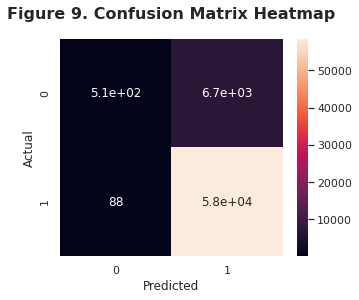

In [17]:
# Test the model
X_train, X_test, y_train, y_test = train_test_split(regressiondata[train_cols],regressiondata['loan_status'].astype('int'), test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Creat confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.title('Figure 9. Confusion Matrix Heatmap', weight='bold', fontsize=16, pad=20)
plt.show()


Most factors are statistically significant at the significance level of 0.05 except race_Free. The coefficient of variables is interpreted below.
* income – For a one-unit increase in **income**, we expect the odds of application approval decrease by 0.6% (exp(-0.0006)=1.0006%)), holding all other independent variables constant.
* loan_amount – For a one-unit increase in **loan_amount**, we expect the odds of application approval increase by 0.8%, holding all other independent variables constant.
* applicant_age – For a one-unit increase in **applicant_age**, we expect the odds of application approval increase by 13.1%, holding all other independent variables constant.
* debt_to_income_ratio – For a one-unit increase in **debt_to_income_ratio**, we expect the odds of application approval decrease by 7.28%, holding all other independent variables constant.
* race_Asian – Asian have 119.3% higher odds than American Indian or Alaska native to get application approval, holding all other independent variables constant.
* race_Black or African American – Black or African American have 63.7% higher odds than American Indian or Alaska Native to get application approval, holding all other independent variables constant.
* race_Joint – Joint races have 125.9% higher odds than American Indian or Alaska Native to get application approval, holding all other independent variables constant.
* race_White – White race have 161.5% higher odds than American Indian or Alaska Native to get application approval, holding all other independent variables constant.
* Type_2 – **FHA loan** application has 32.3% higher odds than conventional loan to be approved, holding all other independent variables constant.
* Type_3 – **VA loan** application has 30.6% higher odds than conventional loan to be approved, holding all other independent variables constant.
* Type_4 – **RHS or FSA loan** application has 103.4% lower odds than conventional loan to be approved, holding all other independent variables constant.
* Joint – **Joint** genders has 15.8% higher odds than female to get the application approval, holding all other independent variables constant.
* Male – **Male** has 13.7% lower odds than female to get the application approval, holding all other independent variables constant.

The R square of this regression model is 9.32%, indicating that 9.32% of loan status change can be explained by gender, age, race, loan type, loan amount, debt-to-income ratio and income. This regression analysis implies that the odds of application approved/ denied have positive correlations with loan amount, and have negative correlations with income, age, debt to income ratio. 

However, based on the exploratory data analysis earlier, people with higher income are more likely to get application approval. I attribute this conflict to the autocorrelation between income and debt-to-income ratio. Because the coefficient of income is very small, this conflict will not affect our final analysis conclusion.

### 5 - Recommendations

#### Lower interest rate for young buyers

From the statistical summary, we can see that interest rates stay the same for all age groups despite the difference in number of applications across groups. With a high amount of applications from 25-34 and 35-44 age groups, legislators should focus on helping applicants in these age range. The younger buyers are more likely to have existing liabilities such as student loan, auto loan to pay off. Thus, legislators should consider lowering interest rates for younger buyers in order to give them more possibility to afford a home.

#### Improve approval rate for applicants in minority groups

The analyses on first-time home buyers’ demographic attributes and denial rate by races demonstrate that applicants from minorities have substantially low chance to get their loan mortgage applications approved. As a result, legislators should consider develop regulations to support applicants in minority groups. Nonetheless, nearly 20% of the applications in this dataset do not provide racial information. Our consulting group should helps legislators conduct more research and collect more evidence to verify my initial analysis as well as identify any other complex reasons for low approval rates.

#### Educate buyers to repay their debts as much as possible before applying for home mortgage

There is a strong negative correlation between debt-to-income ratio and application approval rate, indicating that people should evaluate their debt and income before their home mortgage application. Legislators should help educate home buyers on optimizing their debt-to-asset structure, including repaying their debt as much as possible, so that the risk of application being denied can be lower. 

#### Investigate the reasons for extremely low approval rate for RHS/FSA loan applications 

Based on regression analysis, RHS/FSA loan applications are much more likely to be denied than other loan types, and VA loan applications are much more likely to be approved than other types. Government should look into the cause for such big differences in different types of loan, and then adjust the threshold of the loan requirements or provide more guidance to applicants about how to choose the most suitable loan mortgage.

#### Promote FHA loans

Even though conventional loan has more applications overall, only one-third of the applications are from first-time home buyers while FHA loan applications have bigger fraction of first-time home buyers. Legislators should consider promoting FHA loans more extensively to first-time home buyers and potentially adjust loan standards to make it more accessible. 
